In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import gseapy as gp
import scipy

import scanpy as sc
import anndata as ad
import muon as mu
from muon import MuData 

import mowgli
from mowgli.models import MowgliModel
from mowgli.tl import enrich

In [48]:

def create_anndata_from_csv(csv_file, omic_type):
    """Creates an AnnData object from a CSV file."""
    dataset = pd.read_csv(csv_file, index_col=0)  
    adata = ad.AnnData(X=dataset.values)
    adata.obs['cell_id'] = dataset.index  
    adata.var['feature_id'] = dataset.columns 
    return adata

rna_df = pd.read_csv("transcriptomic_dataset.csv", index_col=0)
epigenomic_df = pd.read_csv("epigenomic_dataset.csv", index_col=0)
proteomic_df = pd.read_csv("proteomic_dataset.csv", index_col=0)
metabolomic_df = pd.read_csv("metabolomic_dataset.csv", index_col=0)


rna_adata = ad.AnnData(X=rna_df.values, obs=pd.DataFrame(index=rna_df.index), var=pd.DataFrame(index=rna_df.columns))
epigenomic_adata = ad.AnnData(X=epigenomic_df.values, obs=pd.DataFrame(index=epigenomic_df.index), var=pd.DataFrame(index=epigenomic_df.columns))
proteomic_adata = ad.AnnData(X=proteomic_df.values, obs=pd.DataFrame(index=proteomic_df.index), var=pd.DataFrame(index=proteomic_df.columns))
metabolomic_adata = ad.AnnData(X=metabolomic_df.values, obs=pd.DataFrame(index=metabolomic_df.index), var=pd.DataFrame(index=metabolomic_df.columns))

In [49]:
# fill nans with mean
rna_adata.X = np.nan_to_num(rna_adata.X, nan=np.nanmean(rna_adata.X))
epigenomic_adata.X = np.nan_to_num(epigenomic_adata.X, nan=np.nanmean(epigenomic_adata.X))
proteomic_adata.X = np.nan_to_num(proteomic_adata.X, nan=np.nanmean(proteomic_adata.X))
metabolomic_adata.X = np.nan_to_num(metabolomic_adata.X, nan=np.nanmean(metabolomic_adata.X))

In [50]:
# highly variable genes
sc.pp.highly_variable_genes(rna_adata, n_top_genes=1000)
sc.pp.highly_variable_genes(epigenomic_adata, n_top_genes=1000)
sc.pp.highly_variable_genes(proteomic_adata, n_top_genes=1000)
sc.pp.highly_variable_genes(metabolomic_adata, n_top_genes=1000)

In [53]:
# MuData object
mdata = MuData({
    'rna': rna_adata,
    'epigenomic': epigenomic_adata,
    'proteomic': proteomic_adata,
    'metabolomic': metabolomic_adata
})

/home/azureuser/.local/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/home/azureuser/.local/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


In [54]:


## Init. MOWGLI MODEL

model = MowgliModel(
    latent_dim=20,
    use_mod_weight=False, 
    h_regularization=1.0,
    w_regularization=1.0,
    eps=0.1,
)

model.train(mdata)

  2%|▏         | 4/200 [03:09<2:34:53, 47.42s/it, loss=168.17137, mass_transported=2.73, loss_inner=-174.13237, inner_steps=10, gpu_memory_allocated=0]  


In [55]:
mdata

MuData object with n_obs × n_vars = 300 × 3800
  var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
  obsm:	'W_OT'
  4 modalities
    rna:	300 x 2000
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'H_OT'
    epigenomic:	300 x 1000
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'H_OT'
    proteomic:	300 x 500
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'H_OT'
    metabolomic:	300 x 300
      var:	'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'H_OT'

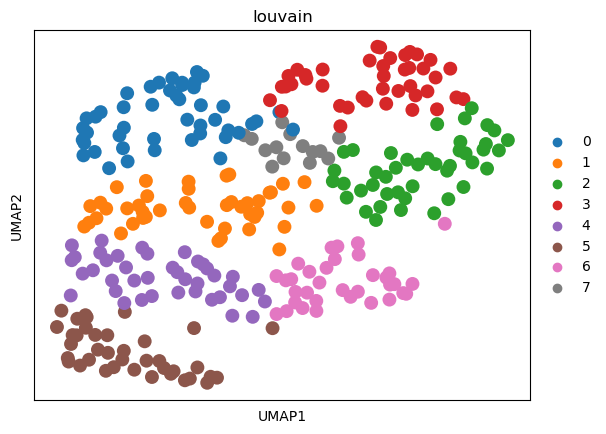

In [56]:
sc.pp.neighbors(mdata, use_rep="W_OT")
sc.tl.umap(mdata)
sc.tl.louvain(mdata)
sc.pl.umap(mdata, color="louvain", save="mowgli_umap_louvain_scsim.png")

In [ ]:
#enr, _ = mowgli.tl.enrich(
#    mdata,
#    mod="rna",
#    n_genes=30,
#    domain_scope="annotated",
#)